In [1]:
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [2]:
from torchvision.datasets import ImageFolder

class ImageFolderWithFilenames(ImageFolder):
    def __getitem__(self, index):
        # Get the original tuple (image, label)
        original_tuple = super().__getitem__(index)

        # Get the image path
        path, _ = self.samples[index]  # self.samples contains (file_path, class_idx)

        # Add the filename to the tuple
        filename = path.split('/')[-1]
        return original_tuple + (filename,)


In [3]:
# Load dataset with the custom class
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/Fourth Year/CPEN 355/'

# List the files in the folder to confirm
import os
os.listdir(folder_path)

#Now we define path of .zip file
zip_file_path = folder_path + 'USTC_SmokeRS.zip'

# Unzip the file
!unzip -q "$zip_file_path" -d /content/dataset

os.listdir('/content/dataset')

#We make sure that the unzipped file contains the expected folder names
class_folders = os.listdir('/content/dataset')
print("Class folders:", class_folders)

dataset = ImageFolderWithFilenames(root='/content/dataset', transform=transform)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/dataset/Cloud/cloud_1.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Class folders: ['Land', 'Smoke', 'Cloud', 'Seaside', 'Haze', 'Dust']


In [4]:
#We then split the data into training, validation and testing

from torch.utils.data import random_split, DataLoader

# Define split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


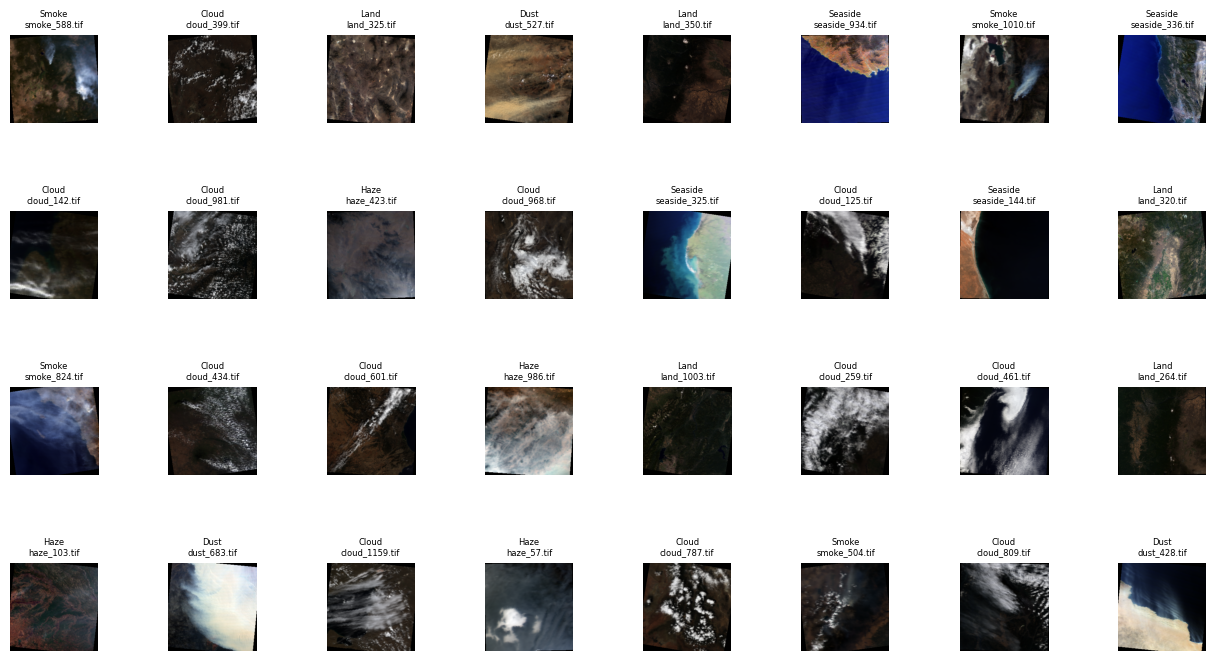

In [5]:
#We visualize that in fact the images are correctly labelled after spliting the dataset

import matplotlib.pyplot as plt
import numpy as np

# Function to display an image grid with labels and filenames
def show_images_with_filenames(images, labels, filenames, class_names):
    # Denormalize the images
    images = images / 2 + 0.5  # Scale back to [0, 1]
    np_images = images.numpy()

    # Create the plot
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))  # 4x8 grid
    fig.subplots_adjust(hspace=1)  # Add space between rows for labels and filenames

    for i, ax in enumerate(axes.flat):
        if i < len(labels):
            # Show the image
            ax.imshow(np.transpose(np_images[i], (1, 2, 0)))  # Rearrange dimensions for plotting

            # Display the label and filename
            label = class_names[labels[i]]
            filename = filenames[i]
            ax.set_title(f"{label}\n{filename}", fontsize=6)  # Show label and filename

            ax.axis('off')  # Turn off axes for a cleaner look
        else:
            ax.axis('off')  # Turn off empty grid cells

    plt.show()

# Get a batch of images, labels, and filenames
dataiter = iter(DataLoader(train_dataset, batch_size=32, shuffle=True))
images, labels, filenames = next(dataiter)

# Display images with their labels and filenames
show_images_with_filenames(images, labels, filenames, dataset.classes)



In [6]:
# Check balance of the classes with how many images are loaded with each class

from collections import Counter

train_labels = [label for _, label, _ in train_dataset]
train_class_counts = Counter(train_labels)

class_names = dataset.classes
class_counts_named = {class_names[idx]: count for idx, count in train_class_counts.items()}

print("Class Distribution with Names:", class_counts_named)
print("Class Index Mapping:", dataset.class_to_idx)

Class Distribution with Names: {'Haze': 701, 'Cloud': 807, 'Seaside': 710, 'Land': 717, 'Smoke': 705, 'Dust': 717}
Class Index Mapping: {'Cloud': 0, 'Dust': 1, 'Haze': 2, 'Land': 3, 'Seaside': 4, 'Smoke': 5}


NOW THAT WE HAVE SPLIT THE DATA; WE START BY BUILDING THE CNN MODEL

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        # Fully connected layers
        self.fc1 = nn.Linear(128, 128)  # Adjust for input size
        self.fc2 = nn.Linear(128, 6)  # 6 output classes

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.global_pool(x) # Apply global average pooling
        x = torch.flatten(x,1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()


WE DEFINE THE LOSS FUNCTION AND OPTIMIZER

In [8]:
import torch.optim as optim

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to correct device
model = model.to(device)

# Define class weights
class_weights = torch.tensor([1.0, 1.0, 1.5, 1.0, 1.0, 2.0]).to(device)

# Loss function: CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer: Adam for faster convergence
optimizer = optim.Adam(model.parameters(), lr=0.001)


WE NOW TRAIN THE MODEL

In [9]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels, _ in train_loader:  # Ignore the filename with "_"
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track the loss
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 1.1559
Epoch 2/10, Loss: 0.9380
Epoch 3/10, Loss: 0.8614
Epoch 4/10, Loss: 0.8209
Epoch 5/10, Loss: 0.8139
Epoch 6/10, Loss: 0.7860
Epoch 7/10, Loss: 0.7562
Epoch 8/10, Loss: 0.7331
Epoch 9/10, Loss: 0.7263
Epoch 10/10, Loss: 0.7228


In [11]:
#Saving trained model
model_save_path = '/content/drive/MyDrive/Fourth Year/CPEN 355/trained_cnn2.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Fourth Year/CPEN 355/trained_cnn2.pth


In [10]:
#We evaluate the model
# Set the model to evaluation mode
model.eval()

val_loss = 0.0
correct = 0
total = 0

# Use no_grad for faster inference and to avoid computing gradients
with torch.no_grad():
    for inputs, labels, _ in val_loader:  # Include `_` if filenames are returned
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average loss and accuracy
val_loss /= len(val_loader)
val_accuracy = 100 * correct / total

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 0.7187, Validation Accuracy: 75.67%


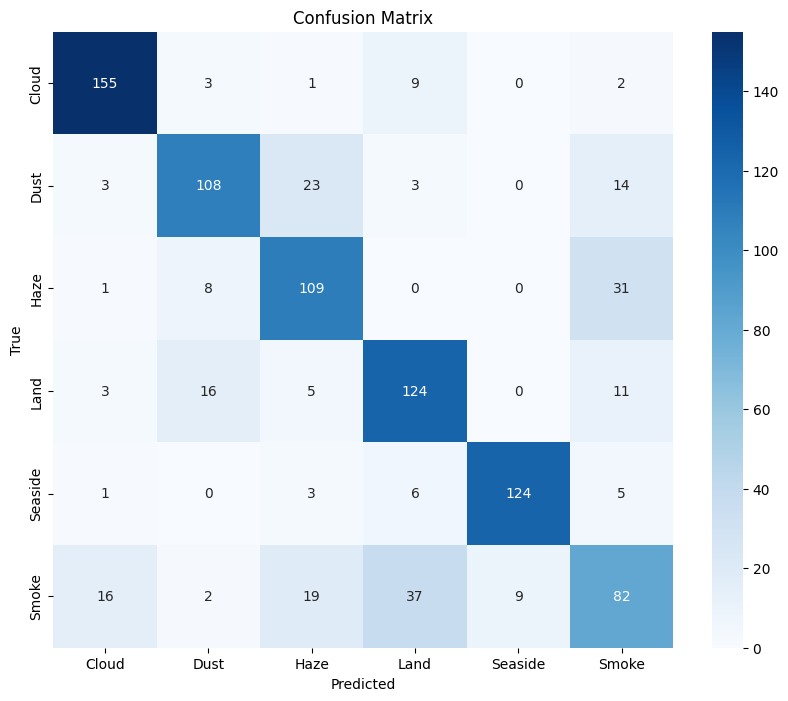

              precision    recall  f1-score   support

       Cloud       0.87      0.91      0.89       170
        Dust       0.79      0.72      0.75       151
        Haze       0.68      0.73      0.71       149
        Land       0.69      0.78      0.73       159
     Seaside       0.93      0.89      0.91       139
       Smoke       0.57      0.50      0.53       165

    accuracy                           0.75       933
   macro avg       0.75      0.75      0.75       933
weighted avg       0.75      0.75      0.75       933



In [12]:
#We do a confusion matrix to see where it performed worse
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Collect predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels, _ in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = dataset.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report (precision, recall, F1-score)
print(classification_report(all_labels, all_preds, target_names=class_names))
